In [10]:
import os
import json
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import chain

import numpy as np
import pandas as pd
from tqdm import tqdm


import nibabel as nib
import matplotlib.pyplot as plt

In [7]:
DIR_PELVIS = os.path.join(os.getcwd(), "..", "data", "Task1", "pelvis")
HU_THRESHOLD = 2000
list_pelvis_image_dir = [os.path.join(DIR_PELVIS, f) for f in os.listdir(DIR_PELVIS) if f.startswith("1P")]

DIR_LABELS = os.path.join(os.getcwd(), "..", "labels")
FILE_MISSING = os.path.join(DIR_LABELS, "missing_Ömer.txt")
LABELS_RAW = os.path.join(DIR_LABELS, "labels_raw.json")

_IGNORE_MR_NA = True

In [4]:
df_stats = pd.read_json(os.path.join(DIR_LABELS, "ct_hu_stats_pelvis.json"))
with open(LABELS_RAW, "r") as f:
    labels_raw_1 = json.load(f)["type1"]
df_labels_1 = pd.DataFrame([
    {"id": k, **v} 
    for item in labels_raw_1 
    for k, v in item.items()
])
with open(FILE_MISSING, "r") as f:
    list_missing = [line.strip() for line in f.readlines()]
df_stats_available = df_stats[~df_stats["id"].isin(list_missing)]
df_stats_available

,id,num_slices,slice_indexes,HU_above_2000,max_HU
29,1PA073,98,[],0,1529
30,1PA070,116,"[50, 51, 52, 54, 55, 56, 57]",7,3000
33,1PA080,98,"[35, 36, 37, 38, 39, 40, 41, 42]",8,3000
34,1PA081,119,"[44, 45, 46, 47, 48, 50, 51, 52, 53]",9,3000
38,1PA062,146,[],0,1471
...,...,...,...,...,...
175,1PC085,101,"[22, 23, 24]",3,2836
176,1PC088,104,[29],1,2192
177,1PC096,87,[49],1,2781
178,1PC098,104,"[42, 43, 44]",3,3000


In [8]:
df_labels_1_pelvis = df_labels_1[df_labels_1["body_part"] == "pelvis"]
if _IGNORE_MR_NA:
    df_labels_1_pelvis = df_labels_1_pelvis[df_labels_1_pelvis['mr_start'].notna()]
df_labels_1_pelvis[["mr_start", "mr_end", "ct_start", "ct_end"]] = \
    df_labels_1_pelvis[["mr_start", "mr_end", "ct_start", "ct_end"]].astype(int).sort_index()
df_labels_1_pelvis

,id,mr_start,mr_end,ct_start,ct_end,body_part
50,1PA118,0,104,3,76,pelvis
51,1PA133,74,82,74,82,pelvis
52,1PA136,98,121,100,121,pelvis
53,1PA147,45,53,45,53,pelvis
54,1PA151,47,53,46,54,pelvis
55,1PA152,56,69,56,68,pelvis
56,1PA155,6,131,15,86,pelvis
57,1PA163,0,79,0,64,pelvis
61,1PA169,4,97,8,82,pelvis
62,1PA170,25,39,25,39,pelvis


In [11]:
df_labels_1_pelvis_ood = df_labels_1_pelvis[["id", "ct_start", "ct_end"]]
df_labels_1_pelvis_ood["slice_indexes"] = df_labels_1_pelvis_ood.apply(lambda x: list(range(x["ct_start"], x["ct_end"] + 1)), axis=1)
df_labels_1_pelvis_ood = df_labels_1_pelvis_ood[["id", "slice_indexes"]]
df_labels_1_pelvis_ood = df_labels_1_pelvis_ood.groupby("id").agg(lambda x: list(chain.from_iterable(x))).reset_index()
df_labels_1_pelvis_ood

/tmp/ipykernel_1998944/2100416103.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels_1_pelvis_ood["slice_indexes"] = df_labels_1_pelvis_ood.apply(lambda x: list(range(x["ct_start"], x["ct_end"] + 1)), axis=1)


,id,slice_indexes
0,1PA065,"[93, 94, 95, 96, 97]"
1,1PA079,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17..."
2,1PA114,"[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 7..."
3,1PA118,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ..."
4,1PA133,"[74, 75, 76, 77, 78, 79, 80, 81, 82]"
5,1PA136,"[100, 101, 102, 103, 104, 105, 106, 107, 108, ..."
6,1PA147,"[45, 46, 47, 48, 49, 50, 51, 52, 53]"
7,1PA151,"[46, 47, 48, 49, 50, 51, 52, 53, 54]"
8,1PA152,"[56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 6..."
9,1PA155,"[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2..."


🧠 MR Image Intensity Analysis
Found 182 NIfTI files
  ... and 177 more files
Loading and extracting intensities...
Processing 1/182
Processing 2/182
Processing 3/182
Processing 4/182
Processing 5/182
Processing 6/182
Processing 7/182
Processing 8/182
Processing 9/182
Processing 10/182
Processing 11/182
Processing 12/182
Processing 13/182
Processing 14/182
Processing 15/182
Processing 16/182
Processing 17/182
Processing 18/182
Processing 19/182
Processing 20/182
Processing 21/182
Processing 22/182
Processing 23/182
Processing 24/182
Processing 25/182
Processing 26/182
Processing 27/182
Processing 28/182
Processing 29/182
Processing 30/182
Processing 31/182
Processing 32/182
Processing 33/182
Processing 34/182
Processing 35/182
Processing 36/182
Processing 37/182
Processing 38/182
Processing 39/182
Processing 40/182
Processing 41/182
Processing 42/182
Processing 43/182
Processing 44/182
Processing 45/182
Processing 46/182
Processing 47/182
Processing 48/182
Processing 49/182
Processing 5

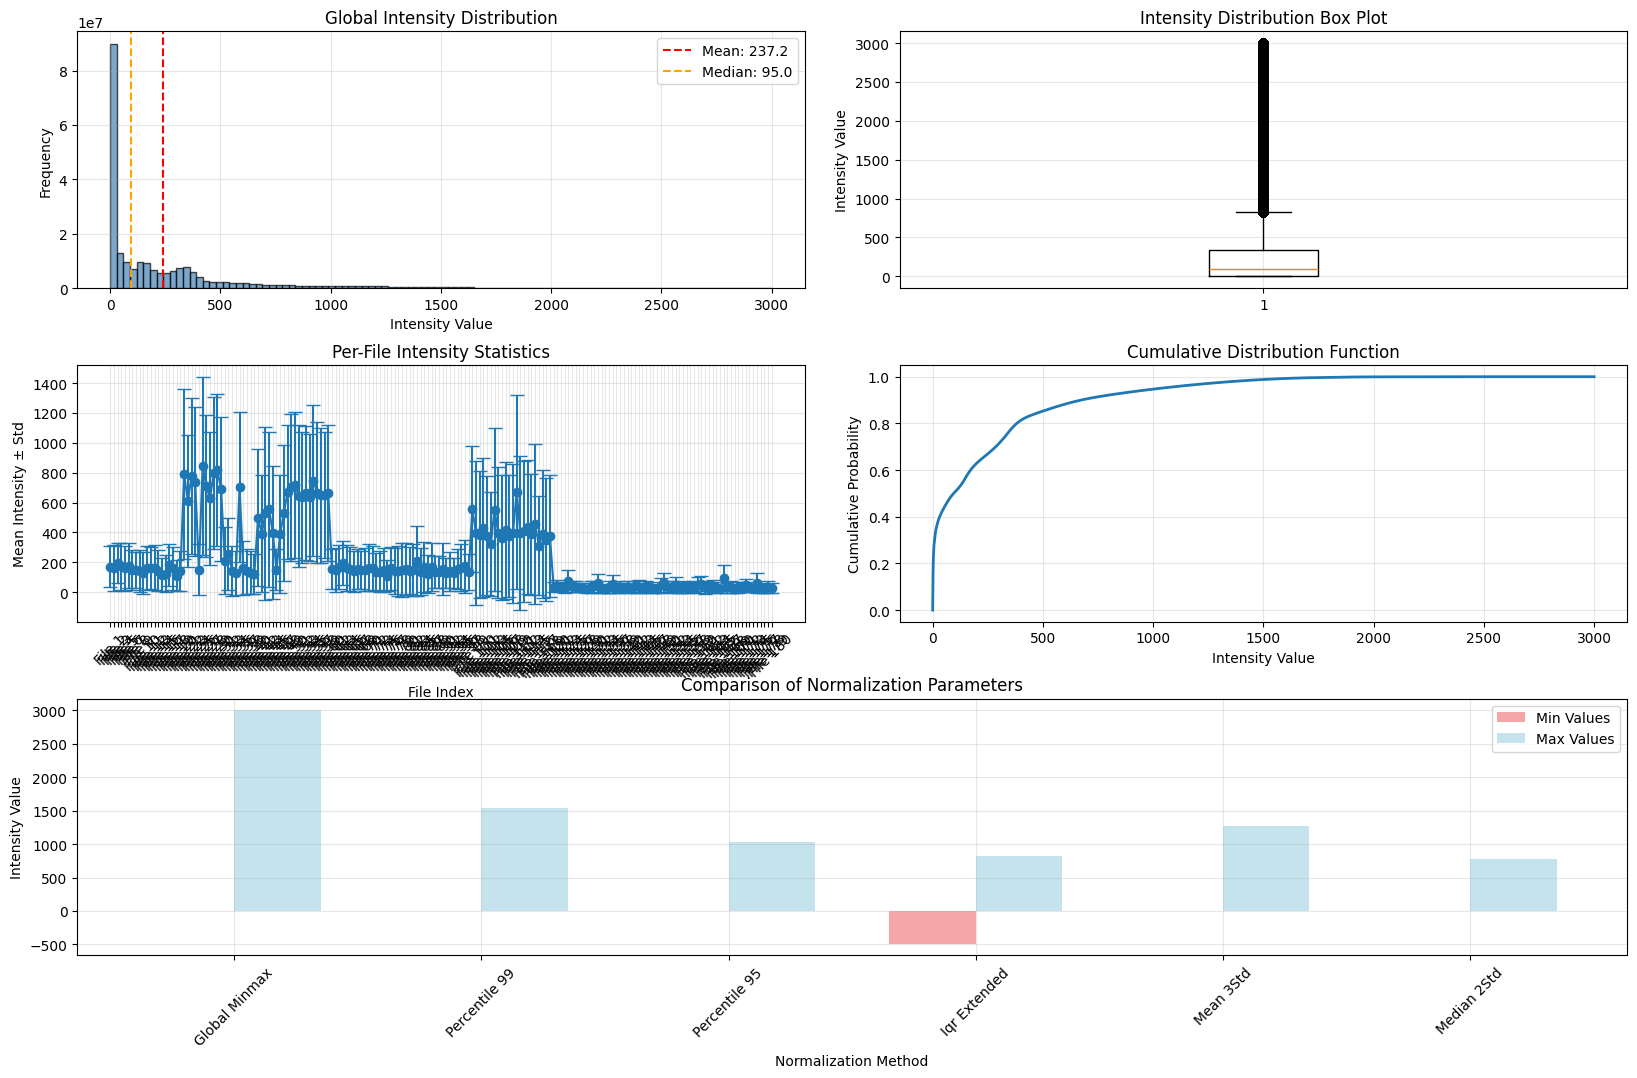

MR IMAGE INTENSITY ANALYSIS REPORT
Dataset: /home/user/lyeyang/projects/sct-ood-dataset/data/Task1/pelvis
Number of files: 182
Total voxels analyzed: 226,912,122

GLOBAL INTENSITY STATISTICS
----------------------------------------
Mean:              237.19
Median:            95.00
Standard Deviation: 342.22
Min:               0.00
Max:               3000.00
Range:             3000.00
Skewness:          2.164
Kurtosis:          4.996

PERCENTILES
----------------------------------------
1st percentile:    0.06
5th percentile:    0.57
25th percentile:   4.41
75th percentile:   333.71
95th percentile:   1029.92
99th percentile:   1540.40
IQR:               329.30

RECOMMENDED NORMALIZATION PARAMETERS
----------------------------------------

GLOBAL MINMAX:
  Min: 0.00
  Max: 3000.00
  Range: 3000.00
  Description: Global min-max (sensitive to outliers)
  Use case: When you need full dynamic range

PERCENTILE 99:
  Min: 0.06
  Max: 1540.40
  Range: 1540.34
  Description: 1st-99th percenti

In [12]:
import os
import glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class MRIntensityAnalyzer:
    def __init__(self, data_path):
        self.data_path = Path(data_path)
        self.nii_files = []
        self.intensity_data = {}
        self.global_stats = {}
        self.normalization_params = {}
        
    def find_nii_files(self, pattern="**/*.nii.gz"):
        """Find all NIfTI files in the directory"""
        # self.nii_files = list(self.data_path.glob(pattern))
        nii_files = os.listdir(self.data_path)
        nii_files = [os.path.join(self.data_path, f, "mr.nii.gz") for f in nii_files]

        self.nii_files = nii_files
        print(f"Found {len(self.nii_files)} NIfTI files")
        if len(self.nii_files) > 5:
            print(f"  ... and {len(self.nii_files) - 5} more files")
        
        return self.nii_files
    
    def load_and_extract_intensities(self, mask_threshold=0, sample_ratio=0.1):
        print("Loading and extracting intensities...")
        all_intensities = []
        
        for i, nii_file in enumerate(self.nii_files):
            print(f"Processing {i+1}/{len(self.nii_files)}")
            
            try:
                img = nib.load(str(nii_file))
                data = img.get_fdata()
                
                mask = data > mask_threshold
                intensities = data[mask].flatten()
                
                if len(intensities) > 100000:
                    n_samples = max(10000, int(len(intensities) * sample_ratio))
                    idx = np.random.choice(len(intensities), n_samples, replace=False)
                    intensities = intensities[idx]
                
                self.intensity_data[i] = {
                    'intensities': intensities,
                    'shape': data.shape,
                    'n_voxels': np.sum(mask),
                    'stats': self._calculate_stats(intensities)
                }
                
                all_intensities.extend(intensities)
                
            except Exception as e:
                print(f"Error processing {i}: {e}")
                continue
        
        self.all_intensities = np.array(all_intensities)
        self.global_stats = self._calculate_stats(self.all_intensities)
        
        print(f"Total voxels analyzed: {len(self.all_intensities):,}")
        return self.all_intensities
    
    def _calculate_stats(self, intensities):
        """Calculate comprehensive statistics for intensity array"""
        if len(intensities) == 0:
            return None
            
        return {
            'count': len(intensities),
            'min': np.min(intensities),
            'max': np.max(intensities),
            'mean': np.mean(intensities),
            'median': np.median(intensities),
            'std': np.std(intensities),
            'p1': np.percentile(intensities, 1),
            'p5': np.percentile(intensities, 5),
            'p10': np.percentile(intensities, 10),
            'p25': np.percentile(intensities, 25),
            'p75': np.percentile(intensities, 75),
            'p90': np.percentile(intensities, 90),
            'p95': np.percentile(intensities, 95),
            'p99': np.percentile(intensities, 99),
            'iqr': np.percentile(intensities, 75) - np.percentile(intensities, 25),
            'skewness': stats.skew(intensities),
            'kurtosis': stats.kurtosis(intensities)
        }
    
    def calculate_normalization_parameters(self):
        gs = self.global_stats
        
        self.normalization_params = {
            'global_minmax': {
                'min': gs['min'],
                'max': gs['max'],
                'description': 'Global min-max (sensitive to outliers)',
                'use_case': 'When you need full dynamic range'
            },
            
            'percentile_99': {
                'min': gs['p1'],
                'max': gs['p99'],
                'description': '1st-99th percentile (robust)',
                'use_case': 'Recommended for most MR applications'
            },
            
            'percentile_95': {
                'min': gs['p5'],
                'max': gs['p95'],
                'description': '5th-95th percentile (very robust)',
                'use_case': 'When images have significant noise/artifacts'
            },
            
            'iqr_extended': {
                'min': gs['p25'] - 1.5 * gs['iqr'],
                'max': gs['p75'] + 1.5 * gs['iqr'],
                'description': 'IQR ± 1.5×IQR (outlier detection method)',
                'use_case': 'Statistical outlier removal'
            },
            
            'mean_3std': {
                'min': max(0, gs['mean'] - 3 * gs['std']),
                'max': gs['mean'] + 3 * gs['std'],
                'description': 'Mean ± 3 standard deviations',
                'use_case': 'Assumes normal distribution'
            },
            
            'median_2std': {
                'min': max(0, gs['median'] - 2 * gs['std']),
                'max': gs['median'] + 2 * gs['std'],
                'description': 'Median ± 2 standard deviations',
                'use_case': 'Robust center with controlled range'
            }
        }
        
        return self.normalization_params
    
    def plot_analysis(self, figsize=(20, 12)):
        """Create comprehensive visualization of intensity analysis"""
        fig = plt.figure(figsize=figsize)
        gs_plot = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
        
        # 1. Global histogram
        ax1 = fig.add_subplot(gs_plot[0, :2])
        plt.hist(self.all_intensities, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
        plt.axvline(self.global_stats['mean'], color='red', linestyle='--', label=f"Mean: {self.global_stats['mean']:.1f}")
        plt.axvline(self.global_stats['median'], color='orange', linestyle='--', label=f"Median: {self.global_stats['median']:.1f}")
        plt.xlabel('Intensity Value')
        plt.ylabel('Frequency')
        plt.title('Global Intensity Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Box plot
        ax2 = fig.add_subplot(gs_plot[0, 2:])
        plt.boxplot(self.all_intensities, vert=True)
        plt.ylabel('Intensity Value')
        plt.title('Intensity Distribution Box Plot')
        plt.grid(True, alpha=0.3)
        
        # 3. Per-file statistics
        ax3 = fig.add_subplot(gs_plot[1, :2])
        file_names = list(self.intensity_data.keys())
        file_means = [self.intensity_data[f]['stats']['mean'] for f in file_names]
        file_stds = [self.intensity_data[f]['stats']['std'] for f in file_names]
        
        x_pos = range(len(file_names))
        plt.errorbar(x_pos, file_means, yerr=file_stds, fmt='o-', capsize=5)
        plt.xlabel('File Index')
        plt.ylabel('Mean Intensity ± Std')
        plt.title('Per-File Intensity Statistics')
        plt.xticks(x_pos, [f"File {i+1}" for i in x_pos], rotation=45)
        plt.grid(True, alpha=0.3)
        
        # 4. Cumulative distribution
        ax4 = fig.add_subplot(gs_plot[1, 2:])
        sorted_intensities = np.sort(self.all_intensities)
        cumulative = np.arange(1, len(sorted_intensities) + 1) / len(sorted_intensities)
        plt.plot(sorted_intensities, cumulative, linewidth=2)
        plt.xlabel('Intensity Value')
        plt.ylabel('Cumulative Probability')
        plt.title('Cumulative Distribution Function')
        plt.grid(True, alpha=0.3)
        
        # 5. Normalization comparison
        ax5 = fig.add_subplot(gs_plot[2, :])
        methods = list(self.normalization_params.keys())
        min_vals = [self.normalization_params[m]['min'] for m in methods]
        max_vals = [self.normalization_params[m]['max'] for m in methods]
        
        x_pos = np.arange(len(methods))
        width = 0.35
        
        plt.bar(x_pos - width/2, min_vals, width, label='Min Values', alpha=0.7, color='lightcoral')
        plt.bar(x_pos + width/2, max_vals, width, label='Max Values', alpha=0.7, color='lightblue')
        
        plt.xlabel('Normalization Method')
        plt.ylabel('Intensity Value')
        plt.title('Comparison of Normalization Parameters')
        plt.xticks(x_pos, [m.replace('_', ' ').title() for m in methods], rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def create_summary_report(self):
        """Generate detailed summary report"""
        print("="*80)
        print("MR IMAGE INTENSITY ANALYSIS REPORT")
        print("="*80)
        print(f"Dataset: {self.data_path}")
        print(f"Number of files: {len(self.nii_files)}")
        print(f"Total voxels analyzed: {self.global_stats['count']:,}")
        print()
        
        print("GLOBAL INTENSITY STATISTICS")
        print("-"*40)
        gs = self.global_stats
        print(f"Mean:              {gs['mean']:.2f}")
        print(f"Median:            {gs['median']:.2f}")
        print(f"Standard Deviation: {gs['std']:.2f}")
        print(f"Min:               {gs['min']:.2f}")
        print(f"Max:               {gs['max']:.2f}")
        print(f"Range:             {gs['max'] - gs['min']:.2f}")
        print(f"Skewness:          {gs['skewness']:.3f}")
        print(f"Kurtosis:          {gs['kurtosis']:.3f}")
        print()
        
        print("PERCENTILES")
        print("-"*40)
        print(f"1st percentile:    {gs['p1']:.2f}")
        print(f"5th percentile:    {gs['p5']:.2f}")
        print(f"25th percentile:   {gs['p25']:.2f}")
        print(f"75th percentile:   {gs['p75']:.2f}")
        print(f"95th percentile:   {gs['p95']:.2f}")
        print(f"99th percentile:   {gs['p99']:.2f}")
        print(f"IQR:               {gs['iqr']:.2f}")
        print()
        
        print("RECOMMENDED NORMALIZATION PARAMETERS")
        print("-"*40)
        for method, params in self.normalization_params.items():
            print(f"\n{method.upper().replace('_', ' ')}:")
            print(f"  Min: {params['min']:.2f}")
            print(f"  Max: {params['max']:.2f}")
            print(f"  Range: {params['max'] - params['min']:.2f}")
            print(f"  Description: {params['description']}")
            print(f"  Use case: {params['use_case']}")
    
    def export_normalization_params(self, output_file="normalization_params.txt"):
        """Export normalization parameters to file"""
        with open(output_file, 'w') as f:
            f.write("MR Image Normalization Parameters\n")
            f.write("="*50 + "\n\n")
            
            for method, params in self.normalization_params.items():
                f.write(f"{method.upper().replace('_', ' ')}:\n")
                f.write(f"min_val = {params['min']:.6f}\n")
                f.write(f"max_val = {params['max']:.6f}\n")
                f.write(f"# {params['description']}\n")
                f.write(f"# Use case: {params['use_case']}\n\n")
        
        print(f"Normalization parameters exported to {output_file}")
    
    def get_recommendations(self):
        """Get specific recommendations based on data characteristics"""
        gs = self.global_stats
        recommendations = []
        
        # Check for outliers
        outlier_ratio = (gs['count'] - len(self.all_intensities[
            (self.all_intensities >= gs['p5']) & (self.all_intensities <= gs['p95'])
        ])) / gs['count']
        
        if outlier_ratio > 0.1:
            recommendations.append("HIGH OUTLIER PRESENCE: Use percentile_95 method")
        elif outlier_ratio > 0.05:
            recommendations.append("MODERATE OUTLIERS: Use percentile_99 method")
        else:
            recommendations.append("LOW OUTLIERS: percentile_99 or global_minmax acceptable")
        
        # Check distribution shape
        if abs(gs['skewness']) > 1:
            recommendations.append("SKEWED DISTRIBUTION: Consider median_2std method")
        
        if gs['kurtosis'] > 3:
            recommendations.append("HEAVY TAILS: Use robust percentile methods")
        
        # Check dynamic range
        if (gs['max'] - gs['min']) / gs['mean'] > 10:
            recommendations.append("LARGE DYNAMIC RANGE: Avoid global_minmax")
        
        return recommendations

# Example usage and analysis pipeline
def analyze_mr_dataset(data_path):
    
    # Initialize analyzer
    analyzer = MRIntensityAnalyzer(data_path)
    
    # Find NIfTI files
    files = analyzer.find_nii_files()
    if not files:
        print(f"No NIfTI files found in {data_path}")
        return None
    
    # Extract intensities
    analyzer.load_and_extract_intensities(mask_threshold=0, sample_ratio=0.1)
    
    # Calculate normalization parameters
    analyzer.calculate_normalization_parameters()
    
    # Generate visualizations
    analyzer.plot_analysis()
    
    # Print summary report
    analyzer.create_summary_report()
    
    # Get recommendations
    recommendations = analyzer.get_recommendations()
    print("\nRECOMMENDATIONS")
    print("-"*40)
    for rec in recommendations:
        print(f"• {rec}")
    
    # Export parameters
    analyzer.export_normalization_params()
    
    return analyzer

# Utility functions for applying normalization
# def normalize_image(image_data, min_val, max_val, target_range=(0, 1)):
#     """
#     Apply min-max normalization to image data
    
#     Args:
#         image_data (np.array): Input image data
#         min_val (float): Minimum value for normalization
#         max_val (float): Maximum value for normalization
#         target_range (tuple): Target range for normalized values
    
#     Returns:
#         np.array: Normalized image data
#     """
#     # Clip values to the specified range
#     clipped = np.clip(image_data, min_val, max_val)
    
#     # Normalize to [0, 1]
#     normalized = (clipped - min_val) / (max_val - min_val)
    
#     # Scale to target range
#     target_min, target_max = target_range
#     scaled = normalized * (target_max - target_min) + target_min
    
#     return scaled

def apply_normalization_to_file(input_file, output_file, min_val, max_val, target_range=(0, 1)):
    """
    Apply normalization to a single NIfTI file
    
    Args:
        input_file (str): Path to input .nii.gz file
        output_file (str): Path to output .nii.gz file
        min_val (float): Minimum value for normalization
        max_val (float): Maximum value for normalization
        target_range (tuple): Target range for normalized values
    """
    # Load image
    img = nib.load(input_file)
    data = img.get_fdata()
    
    # Apply normalization
    # normalized_data = normalize_image(data, min_val, max_val, target_range)
    normalized_data = data
    
    # Save normalized image
    normalized_img = nib.Nifti1Image(normalized_data, img.affine, img.header)
    nib.save(normalized_img, output_file)
    
    print(f"Not Normalized {input_file} -> {output_file}")

# Quick analysis function for Jupyter notebook
def quick_mr_analysis(data_path, show_plots=True):
    
    print("🧠 MR Image Intensity Analysis")
    print("="*50)
    
    # try:
    analyzer = analyze_mr_dataset(data_path)
    
    if analyzer is None:
        return None
    
    # Return key results
    results = {
        'global_stats': analyzer.global_stats,
        'normalization_params': analyzer.normalization_params,
        'file_count': len(analyzer.nii_files),
        'recommendations': analyzer.get_recommendations(),
        'analyzer': analyzer  # For further analysis
    }
    
    print("\n✅ Analysis complete!")
    print(f"📁 Processed {results['file_count']} files")
    print(f"🔢 Analyzed {results['global_stats']['count']:,} voxels")
    
    return results
        

# Example usage:
if __name__ == "__main__":
    # Set your data path here
    DATA_PATH = "/home/user/lyeyang/projects/sct-ood-dataset/data/Task1/pelvis"  # Update this path
    
    # Run analysis
    results = quick_mr_analysis(DATA_PATH)
    
    if results:
        # Print recommended normalization values
        print("\n🎯 RECOMMENDED NORMALIZATION VALUES:")
        print("-"*50)
        
        # Most commonly used method for MR images
        recommended = results['normalization_params']['percentile_99']
        print(f"Min value: {recommended['min']:.4f}")
        print(f"Max value: {recommended['max']:.4f}")
        print(f"Method: {recommended['description']}")
        
        # Example normalization code
        print("\n💻 EXAMPLE NORMALIZATION CODE:")
        print("-"*50)
        print(f"# Using recommended parameters, min_val = {recommended['min']:.4f}, max_val = {recommended['max']:.4f}")


# Normalize single image
# def normalize_mr_image(image_path, output_path):
#     img = nib.load(image_path)
#     data = img.get_fdata()
    
#     # Apply normalization to [0, 1] range
#     normalized = np.clip((data - {recommended['min']}) / ({recommended['max']} - {recommended['min']}), 0, 1)
    
#     # Save normalized image
#     normalized_img = nib.Nifti1Image(normalized, img.affine, img.header)
#     nib.save(normalized_img, output_path)

# Batch normalization
# input_dir = "path/to/input"
# output_dir = "path/to/output"
# for nii_file in glob.glob(os.path.join(input_dir, "*.nii.gz")):
#     output_file = os.path.join(output_dir, os.path.basename(nii_file))
#     # normalize_mr_image(nii_file, output_file)

# Alternative: Create DataFrame summary for easy viewing
def create_summary_dataframe(analyzer):
    """Create pandas DataFrame with summary statistics"""
    
    # Global stats
    global_df = pd.DataFrame([analyzer.global_stats]).T
    global_df.columns = ['Global']
    
    # Individual file stats
    file_stats = {}
    for filename, data in analyzer.intensity_data.items():
        file_stats[filename] = data['stats']
    
    file_df = pd.DataFrame(file_stats).T
    
    print("GLOBAL STATISTICS:")
    print(global_df.round(2))
    print("\nPER-FILE STATISTICS (first 10 files):")
    print(file_df.head(10).round(2))
    
    return global_df, file_df